# Use BlackJAX with TFP

BlackJAX can take any log-probability function as long as it is compatible with JAX's JIT. In this notebook we show how we can use tensorflow-probability as a modeling language and BlackJAX as an inference library.

We reproduce the Eight Schools example from the [TFP documentation](https://www.tensorflow.org/probability/examples/Eight_Schools) (all credit for the model goes to the TFP team). For this notebook to run you will need to install tfp-nightly:

```bash
pip install tfp-nightly
```

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import blackjax.hmc as hmc
import blackjax.stan_warmup as stan_warmup

## Data

Please refer to the [original TFP example](https://www.tensorflow.org/probability/examples/Eight_Schools) for a description of the problem and the model that is used. This notebook focuses exclusively on the possibility to use TFP as a modeling language and BlackJAX as an inference library.

In [2]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

## Model

In [3]:
model = tfd.JointDistributionSequential([
  tfd.Normal(loc=0., scale=10., name="avg_effect"),  # `mu` above
  tfd.Normal(loc=5., scale=1., name="avg_stddev"),  # `log(tau)` above
  tfd.Independent(tfd.Normal(loc=jnp.zeros(num_schools),
                             scale=jnp.ones(num_schools),
                             name="school_effects_standard"),  # `theta_prime` 
                  reinterpreted_batch_ndims=1),
  lambda school_effects_standard, avg_stddev, avg_effect: (
      tfd.Independent(tfd.Normal(loc=(avg_effect[..., jnp.newaxis] +
                                      jnp.exp(avg_stddev[..., jnp.newaxis]) *
                                      school_effects_standard),  # `theta` above
                                 scale=treatment_stddevs),
                      name="treatment_effects",  # `y` above
                      reinterpreted_batch_ndims=1))
])

def target_logprob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return model.log_prob((
      avg_effect, avg_stddev, school_effects_standard, treatment_effects))

potential_fn = lambda x: -target_logprob_fn(**x)

In [4]:
rng_key = jax.random.PRNGKey(0)
initial_position = {
    'avg_effect': jnp.zeros([]),
    'avg_stddev': jnp.zeros([]),
    'school_effects_standard': jnp.ones([num_schools])
}

Let us first run the window adaptation to find a good value for the step size and for the inverse mass matrix. As in the original example we will run the integrator 3 times at each step.

In [5]:
kernel_factory = lambda step_size, inverse_mass_matrix: hmc.kernel(potential_fn, step_size, inverse_mass_matrix, 3)

last_state, (step_size, inverse_mass_matrix), _ = stan_warmup.run(
    rng_key,
    kernel_factory,
    hmc.new_state(initial_position, potential_fn),
    3000
)

BlackJAX does not come with an inference loop (yet) so you have to implement it yourself, which just takes a few lines with JAX:

In [6]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

# Build the kernel using the step size and inverse mass matrix returned from the window adaptation
kernel = kernel_factory(step_size, inverse_mass_matrix)

# Sample from the posterior distribution
states, infos = inference_loop(rng_key, kernel, last_state, 5000)

Extra information about the inference is contained in the `infos` namedtuple. Let us compute the average acceptance rate:

In [7]:
acceptance_rate = np.mean(infos.acceptance_probability)
print(f"Acceptance rate: {acceptance_rate:.2f}")

Acceptance rate: 0.61


The samples are contained as a dictionnary in `states.position`. Let us compute the posterior of the school treatment effect:

In [8]:
samples = states.position
school_effects_samples = (
    samples['avg_effect'][:, np.newaxis] +
    np.exp(samples['avg_stddev'])[:, np.newaxis] * samples['school_effects_standard'])

And now let us plot the correponding chains and distributions:

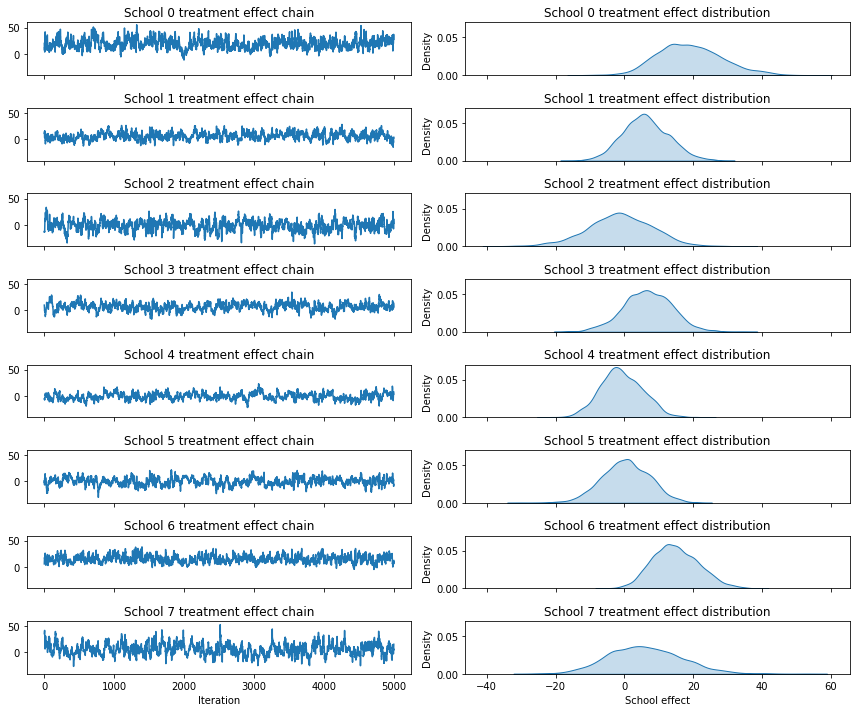

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()